# mom6_bathy Notebook Gallery
## Spherical grid with equatorial refinement

In this notebook, we create a spherical grid with uniform resolution. We then increase the resolution around the equator by a factor of two by providing new, custom x and y coordinates array for the supergrid.

## 1. Import Modules

In [1]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
from mom6_bathy.mom6grid import mom6grid
from mom6_bathy.mom6bathy import mom6bathy

## 2. Create a horizontal MOM6 grid

Spherical grid. x coordinates interval= [0, 360] degrees. y coordinates interval = [-80,+80] degrees

In [2]:
# Instantiate a MOM6 grid instance
grd = mom6grid(
        nx         = 180,         # Number of grid points in x direction
        ny         = 80,          # Number of grid points in y direction
        config     = "spherical", # Grid configuration. Valid values: 'cartesian', 'mercator', 'spherical'
        axis_units = "degrees",   # Grid axis units. Valid values: 'degrees', 'm', 'km'
        lenx       = 360.0,       # grid length in x direction, e.g., 360.0 (degrees)
        leny       = 160,         # grid length in y direction
        cyclic_x   = "True",      # reentrant, spherical domain
        ystart     = -80          # start/end 10 degrees above/below poles to avoid singularity 
)

Updating supergrid...


### Plot grid properties:

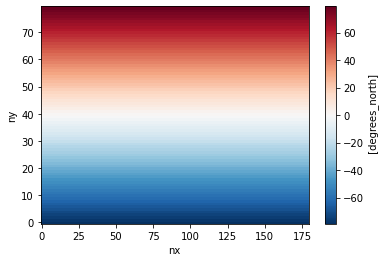

In [3]:
grd.tlat.plot();

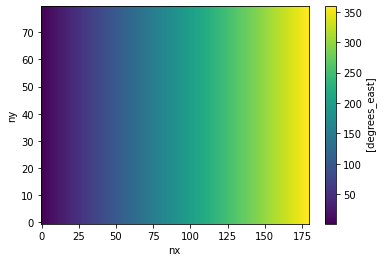

In [4]:
grd.tlon.plot();

### *Customize the grid resolution around the equator*
To do so, we provide new x and y coordinate arrays for the supergrid

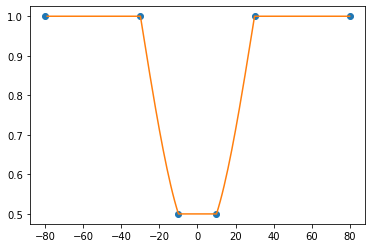

In [5]:
# First, define a refinement function along longitutes:
from scipy import interpolate
f = 0.5
r_y = [-80,-30,-10,10,30,80] # transition latitudes
r_f = [1,1,f,f,1,1]          # inverse refinement factors at transition latitudes
interp_func = interpolate.interp1d(r_y, r_f, kind=3)
r_f_mapped = interp_func(grd.supergrid.y[1:,0])
r_f_mapped = np.where(r_f_mapped < 1.0, r_f_mapped, 1.0)
r_f_mapped = np.where(r_f_mapped > f, r_f_mapped, f)
plt.plot(r_y, r_f, 'o', grd.supergrid.y[1:,0], r_f_mapped, '-');

Now apply the above refinement function (`r_f_mapped`) to the y coordinates of the original supergrid:

In [6]:
super_dy = grd.supergrid.y[1:,0] - grd.supergrid.y[:-1,0]
super_dy_new = super_dy.mean() * r_f_mapped / r_f_mapped.mean() # normalize
super_y_new = grd.supergrid.y[:,0].copy()
super_y_new[1:] = grd.supergrid.y[0,0] + super_dy_new.cumsum()
xdat, ydat = np.meshgrid(grd.supergrid.x[0,:], super_y_new)

Update the supergrid:

In [7]:
grd.update_supergrid(xdat, ydat)

Updating supergrid...


Confirm that the equatorial resolution is increased by a factor of two:

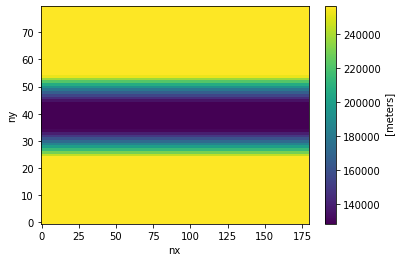

In [8]:
grd.dyt.plot()

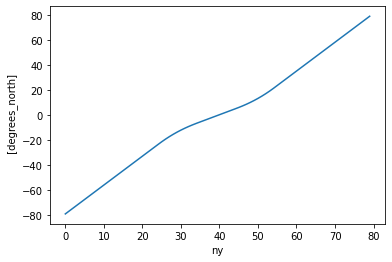

In [9]:
grd.tlat.isel(nx=0).plot()

## 3. Configure the bathymetry

In [10]:
# Instantiate a mom6bathy object associated with the horizontal grid object (grd).
bathy = mom6bathy(grd, min_depth=10.0)

### *flat bottom bathymetry*

In [11]:
# Set the bathymetry to be a flat bottom with a depth of 2000m
bathy.set_flat(D=2000.0)

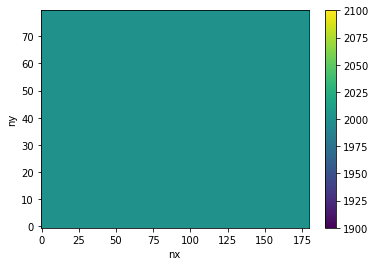

In [12]:
bathy.depth.plot()

## 4. Save the grid and bathymetry files

In [13]:
# supergrid file:
grd.to_netcdf(supergrid_path="./ocean_hgrid_speq.nc")

# ocean_topog:
bathy.to_topog("./ocean_topog_speq.nc")

# SCRIP file:
bathy.to_SCRIP("./SCRIP_speq.nc")

*To create an ESMF mesh file:*

`$ ESMF_Scrip2Unstruct SCRIP_speq.nc ESMFmesh_speq.nc 0`

## Further Steps

### *Initial Conditions*

For this simple model, we choose to adopt an idealized initial conditions (temperature and salinity) predefined in MOM6 internally. To do so, we set the following MOM6 runtime parameters in MOM_input:
```
TS_CONFIG = "fit"     ! find the temperatures that are consistent with the layer densities and salinity S_REF.
T_REF = -1.9          ! A reference temperature used in initialization.
FIT_SALINITY = True   ! If true, accept the prescribed temperature and fit the salinity
```

### *Configure MOM6*

We run the `print_MOM6_runtime_params` method of `bathy` to print out the grid and bathymetry related MOM6 runtime parameters to be set in MOM_input or MOM_override:

In [14]:
bathy.print_MOM6_runtime_params()

TRIPOLAR_N = False
NIGLOBAL = 180
NJGLOBAL = 80
GRID_CONFIG = mosaic
TOPO_CONFIG = file
MAXIMUM_DEPTH = 2000.0
MINIMUM_DEPTH = 10.0
REENTRANT_X = True
GRID_FILE = ???
TOPO_FILE = ???
